curve_db is already loaded
Loading power law fit parameters...
Loaded power law parameters: A=5.69e-04, α=0.393
Conductor range: [14, 99918]

Building conductor to isogeny class mapping...


Building mapping: 100%|█████████████████████████████████████████████████████| 437226/437226 [00:03<00:00, 118184.51it/s]


Unique conductors in database: 62648

Sampling 5000 conductors from power law distribution...


Sampling conductors: 100%|████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5829.82it/s]



Creating conductor distribution plot...
Saved plot: Conductor_sampling/N5000_conductor_distribution.png


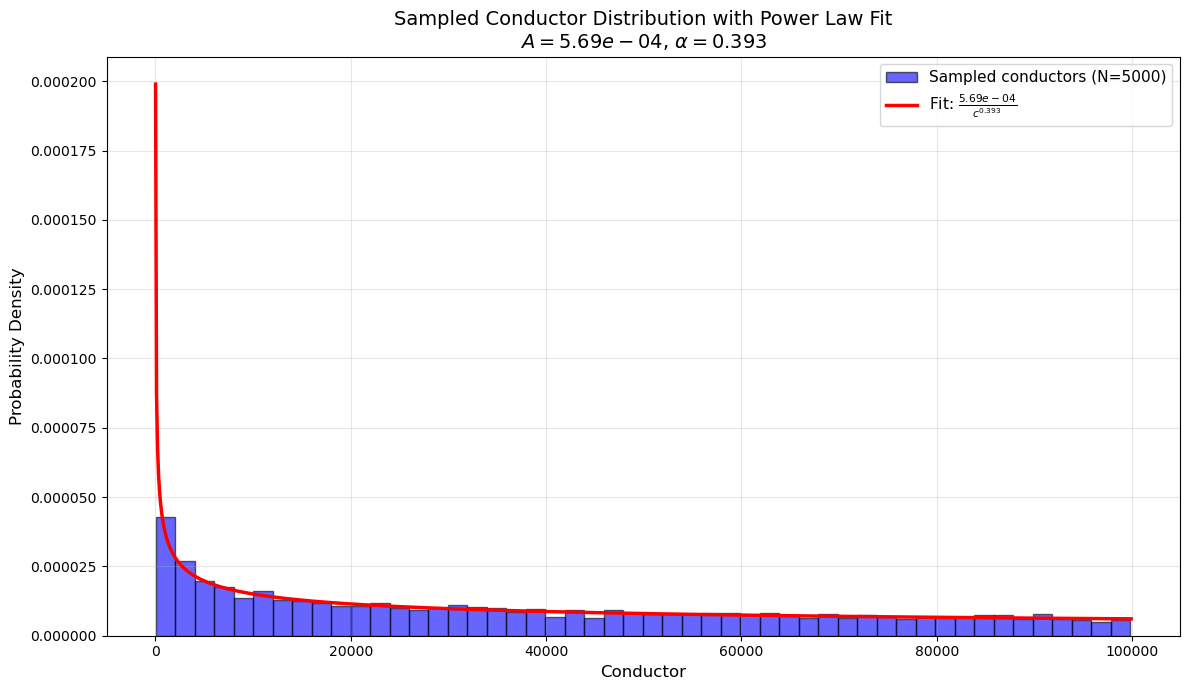


Selecting isogeny classes...


Selecting isogeny classes: 100%|███████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1026254.95it/s]


Selected 3163 isogeny classes


Loading aps: 100%|██████████████████████████████████████████████████████████████| 3163/3163 [00:00<00:00, 636561.76it/s]

Averaging the aps...


Done.

Rank 0: 1194 isogeny classes
Rank 1: 1582 isogeny classes
Rank 2: 377 isogeny classes
Rank 3: 10 isogeny classes

Saved average aps to Conductor_sampling/N5000_conductor_sampling_average_aps.sobj
Saved plot: Conductor_sampling/N5000_conductor_sampling_ap_averages_rank0_vs_rank1.png


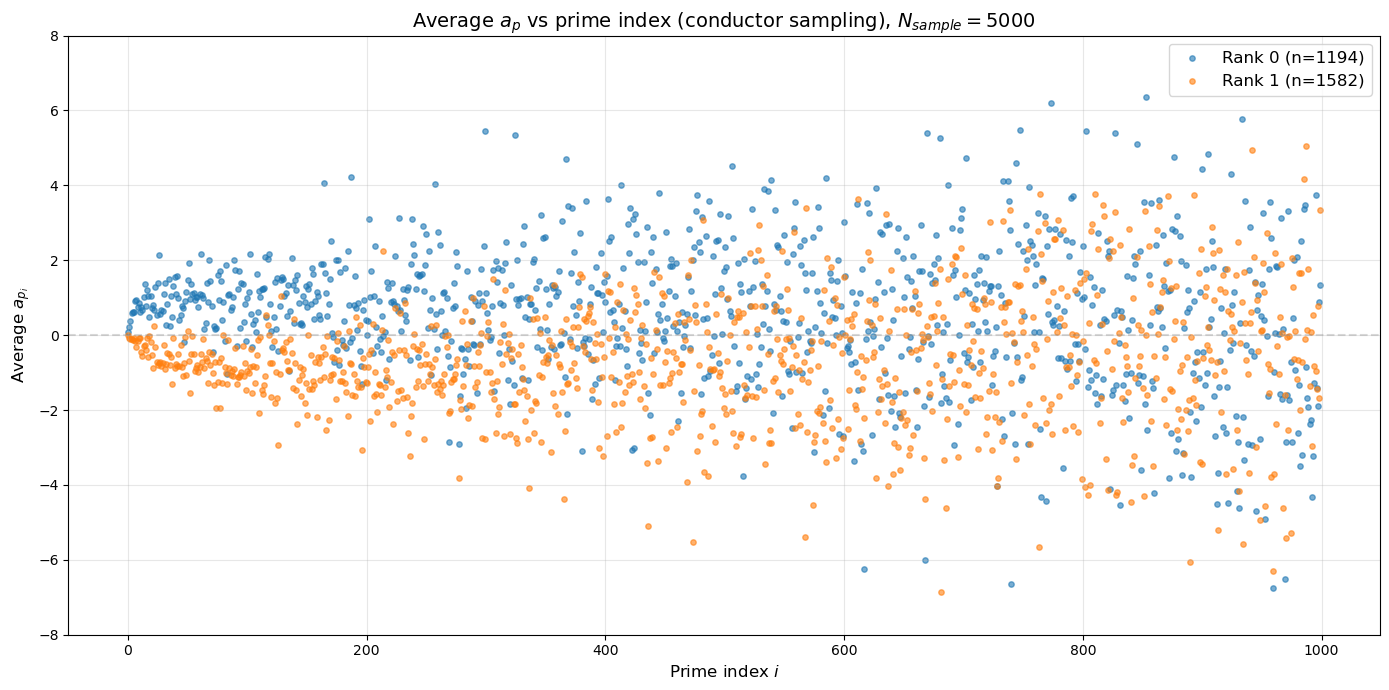

Saved plot: Conductor_sampling/N5000_conductor_sampling_ap_averages_all_ranks.png


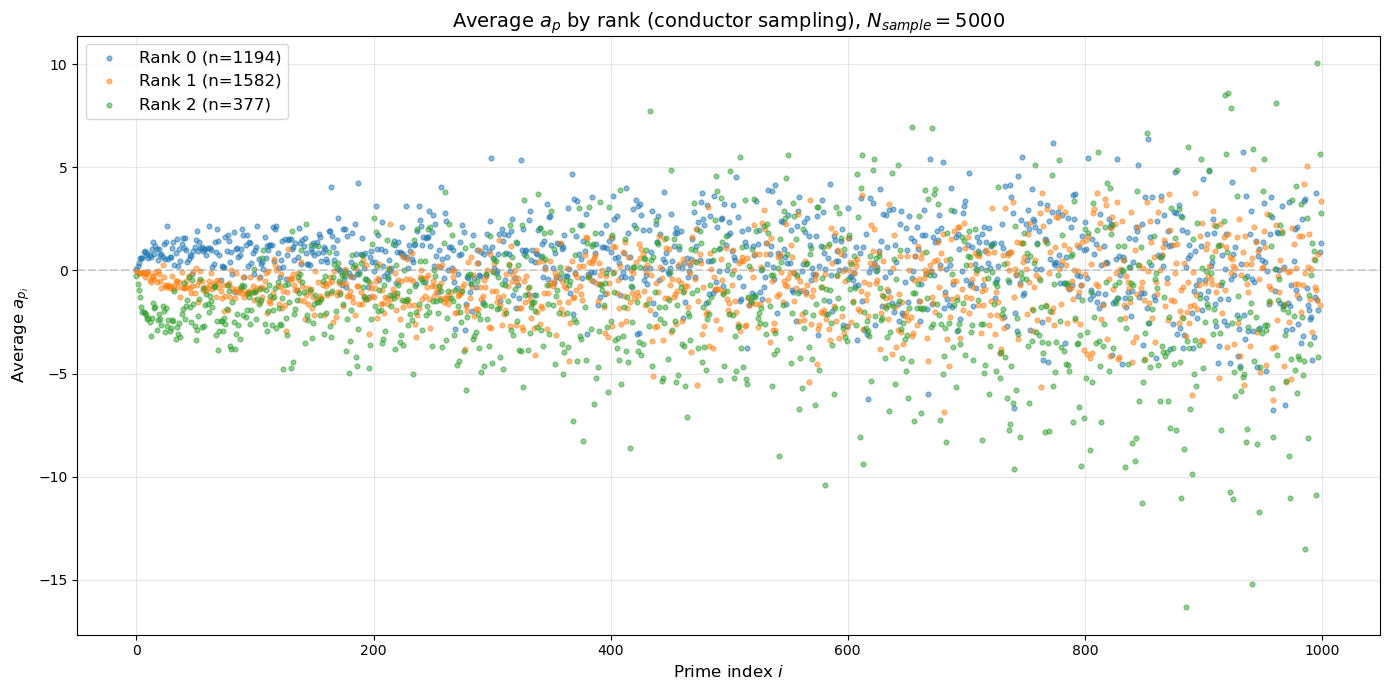


Done!


In [5]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Check if curve_db is loaded
try:
    _ = curve_db
    print("curve_db is already loaded")
except NameError:
    print("Loading curve_db...")
    curve_db = load('Curve Database (Conductor < 100 000)/curve_database_c1_to_100000.sobj')
    print("curve_db loaded successfully")

# Define power law function
def power_law(x, A, alpha):
    """Power law: A / x^alpha"""
    return A / (x**alpha)

# Load the fit parameters (make sure to set nmin and nmax to match the fit)
nmin = -2000
nmax = 2000

print("Loading power law fit parameters...")
fit_params = load(f'HV_curves/({nmin},{nmax})_powerlaw_fit_params.sobj')
A_fit = fit_params['A']
alpha_fit = fit_params['alpha']
c_min = fit_params['c_min']
c_max = fit_params['c_max']
print(f"Loaded power law parameters: A={A_fit:.2e}, α={alpha_fit:.3f}")
print(f"Conductor range: [{c_min}, {c_max}]")

# Build conductor to isogeny class mapping
print("\nBuilding conductor to isogeny class mapping...")
conductor_to_isoclass = {}

for iso in tqdm(curve_db.keys(), desc="Building mapping"):
    c = curve_db[iso]['conductor']
    if c not in conductor_to_isoclass:
        conductor_to_isoclass[c] = []
    conductor_to_isoclass[c].append(iso)

print(f"Unique conductors in database: {len(conductor_to_isoclass)}")

# Sample conductors from the fitted distribution using rejection sampling
def sample_conductors_from_powerlaw(n_samples, A, alpha, c_min, c_max):
    """Sample conductors from power law distribution A/c^alpha using rejection sampling"""
    samples = []
    
    # Convert to Python int for tqdm compatibility
    n_samples = int(n_samples)
    c_min = float(c_min)
    c_max = float(c_max)
    A = float(A)
    alpha = float(alpha)
    
    # Find maximum of pdf in the range for rejection sampling
    pdf_max = power_law(c_min, A, alpha)
    
    attempts = 0
    max_attempts = n_samples * 1000  # Safety limit
    
    with tqdm(total=n_samples, desc="Sampling conductors") as pbar:
        while len(samples) < n_samples and attempts < max_attempts:
            # Propose a conductor uniformly
            c_proposal = np.random.uniform(c_min, c_max)
            
            # Accept with probability proportional to pdf
            pdf_value = power_law(c_proposal, A, alpha)
            u = np.random.uniform(0, pdf_max)
            
            if u <= pdf_value:
                samples.append(int(c_proposal))
                pbar.update(int(1))
            
            attempts += 1
    
    if len(samples) < n_samples:
        print(f"Warning: Only sampled {len(samples)} conductors after {attempts} attempts")
    
    return samples

# Parameters
Nsample = 5000

print(f"\nSampling {Nsample} conductors from power law distribution...")
sampled_conductors = sample_conductors_from_powerlaw(Nsample, A_fit, alpha_fit, c_min, c_max)

# Create output directory
os.makedirs('Conductor_sampling/', exist_ok=True)

# Plot the sampled conductor distribution with fitted curve
print("\nCreating conductor distribution plot...")
plt.figure(figsize=(12, 7))

# Create histogram
counts, bins, patches = plt.hist(sampled_conductors, bins=50, density=True, 
                                  alpha=0.6, color='blue', edgecolor='black',
                                  label=f'Sampled conductors (N={len(sampled_conductors)})')

# Overlay the fitted power law curve
c_range = np.linspace(c_min, c_max, 1000)
pdf_values = power_law(c_range, A_fit, alpha_fit)

# Normalize the power law curve to match histogram normalization
# The histogram is already density-normalized, so we need to normalize the power law too
normalization = np.trapezoid(power_law(c_range, A_fit, alpha_fit), c_range)
pdf_normalized = pdf_values / normalization

plt.plot(c_range, pdf_normalized, 'r-', linewidth=2.5, 
         label=rf'Fit: $\frac{{{A_fit:.2e}}}{{c^{{{alpha_fit:.3f}}}}}$')

plt.xlabel('Conductor', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title(f'Sampled Conductor Distribution with Power Law Fit\n' + 
          rf'$A = {A_fit:.2e}$, $\alpha = {alpha_fit:.3f}$', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig(f'Conductor_sampling/N{Nsample}_conductor_distribution.png', dpi=150)
print(f"Saved plot: Conductor_sampling/N{Nsample}_conductor_distribution.png")
plt.show()
plt.close()

# For each sampled conductor, pick a random isogeny class
print("\nSelecting isogeny classes...")
isogeny_classes = []
cs = []

for c in tqdm(sampled_conductors, desc="Selecting isogeny classes"):
    if c in conductor_to_isoclass:
        # Pick a random isogeny class with this conductor
        iso = random.choice(conductor_to_isoclass[c])
        isogeny_classes.append(iso)
        cs.append(c)
    # If conductor not in database, skip it

print(f"Selected {len(isogeny_classes)} isogeny classes")

# Extract average aps sorted by rank
rk0_aps = []
rk1_aps = []
rk2_aps = []
rk3_aps = []

for iso in tqdm(isogeny_classes, desc="Loading aps"):
    curve = curve_db[iso]
    rk = curve['rank']
    aps = curve['ap_list']
    
    if rk == 0:
        rk0_aps.append(aps)
    elif rk == 1:
        rk1_aps.append(aps)
    elif rk == 2:
        rk2_aps.append(aps)
    elif rk == 3:
        rk3_aps.append(aps)

# Convert to numpy arrays
rk0_aps = np.array(rk0_aps) if len(rk0_aps) > 0 else None
rk1_aps = np.array(rk1_aps) if len(rk1_aps) > 0 else None
rk2_aps = np.array(rk2_aps) if len(rk2_aps) > 0 else None
rk3_aps = np.array(rk3_aps) if len(rk3_aps) > 0 else None

print("Averaging the aps...")
rk0_average_aps = np.mean(rk0_aps, axis=0) if rk0_aps is not None else None
rk1_average_aps = np.mean(rk1_aps, axis=0) if rk1_aps is not None else None
rk2_average_aps = np.mean(rk2_aps, axis=0) if rk2_aps is not None else None
rk3_average_aps = np.mean(rk3_aps, axis=0) if rk3_aps is not None else None
print("Done.")

# Print statistics
print(f"\nRank 0: {len(rk0_aps) if rk0_aps is not None else 0} isogeny classes")
print(f"Rank 1: {len(rk1_aps) if rk1_aps is not None else 0} isogeny classes")
print(f"Rank 2: {len(rk2_aps) if rk2_aps is not None else 0} isogeny classes")
print(f"Rank 3: {len(rk3_aps) if rk3_aps is not None else 0} isogeny classes")

# Save the data
averages_data = {
    'rank_0_average': rk0_average_aps.tolist() if rk0_average_aps is not None else None,
    'rank_1_average': rk1_average_aps.tolist() if rk1_average_aps is not None else None,
    'rank_2_average': rk2_average_aps.tolist() if rk2_average_aps is not None else None,
    'rank_3_average': rk3_average_aps.tolist() if rk3_average_aps is not None else None,
    'rank_0_count': len(rk0_aps) if rk0_aps is not None else 0,
    'rank_1_count': len(rk1_aps) if rk1_aps is not None else 0,
    'rank_2_count': len(rk2_aps) if rk2_aps is not None else 0,
    'rank_3_count': len(rk3_aps) if rk3_aps is not None else 0,
    'isogeny_classes': isogeny_classes,
    'conductors': cs,
    'Nsample': Nsample,
    'powerlaw_A': A_fit,
    'powerlaw_alpha': alpha_fit
}

save(averages_data, f'Conductor_sampling/N{Nsample}_conductor_sampling_average_aps.sobj')
print(f"\nSaved average aps to Conductor_sampling/N{Nsample}_conductor_sampling_average_aps.sobj")

# Save individual arrays
if rk0_average_aps is not None:
    save(rk0_average_aps, f'Conductor_sampling/N{Nsample}_conductor_sampling_rk0_average_aps.sobj')
if rk1_average_aps is not None:
    save(rk1_average_aps, f'Conductor_sampling/N{Nsample}_conductor_sampling_rk1_average_aps.sobj')
if rk2_average_aps is not None:
    save(rk2_average_aps, f'Conductor_sampling/N{Nsample}_conductor_sampling_rk2_average_aps.sobj')
if rk3_average_aps is not None:
    save(rk3_average_aps, f'Conductor_sampling/N{Nsample}_conductor_sampling_rk3_average_aps.sobj')

# Create plots
N = len(rk0_average_aps) if rk0_average_aps is not None else (
     len(rk1_average_aps) if rk1_average_aps is not None else 0)

# Define minimum sample size for plotting
MIN_SAMPLES = 100

if N > 0:
    # Plot 1: Rank 0 vs Rank 1
    plt.figure(figsize=(14, 7))
    plot_count = 0
    if rk0_aps is not None and len(rk0_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk0_average_aps, 
                   label=f"Rank 0 (n={len(rk0_aps)})", alpha=0.6, s=15)
        plot_count += 1
    if rk1_aps is not None and len(rk1_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk1_average_aps, 
                   label=f"Rank 1 (n={len(rk1_aps)})", alpha=0.6, s=15)
        plot_count += 1
    
    if plot_count > 0:
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlabel(r"Prime index $i$", fontsize=12)
        plt.ylabel(r"Average $a_{p_i}$", fontsize=12)
        plt.ylim(-8, 8)
        plt.title(rf"Average $a_p$ vs prime index (conductor sampling), $N_{{sample}}={Nsample}$", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'Conductor_sampling/N{Nsample}_conductor_sampling_ap_averages_rank0_vs_rank1.png', dpi=150)
        print(f"Saved plot: Conductor_sampling/N{Nsample}_conductor_sampling_ap_averages_rank0_vs_rank1.png")
        plt.show()
    else:
        print(f"Skipped rank 0 vs rank 1 plot: insufficient data (need at least {MIN_SAMPLES} curves per rank)")
    plt.close()
    
    # Plot 2: All ranks
    plt.figure(figsize=(14, 7))
    plot_count = 0
    if rk0_aps is not None and len(rk0_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk0_average_aps, 
                   label=f"Rank 0 (n={len(rk0_aps)})", alpha=0.5, s=12)
        plot_count += 1
    if rk1_aps is not None and len(rk1_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk1_average_aps, 
                   label=f"Rank 1 (n={len(rk1_aps)})", alpha=0.5, s=12)
        plot_count += 1
    if rk2_aps is not None and len(rk2_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk2_average_aps, 
                   label=f"Rank 2 (n={len(rk2_aps)})", alpha=0.5, s=12)
        plot_count += 1
    if rk3_aps is not None and len(rk3_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk3_average_aps, 
                   label=f"Rank 3 (n={len(rk3_aps)})", alpha=0.5, s=12)
        plot_count += 1
    
    if plot_count > 0:
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlabel(r"Prime index $i$", fontsize=12)
        plt.ylabel(r"Average $a_{p_i}$", fontsize=12)
        plt.title(rf"Average $a_p$ by rank (conductor sampling), $N_{{sample}}={Nsample}$", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'Conductor_sampling/N{Nsample}_conductor_sampling_ap_averages_all_ranks.png', dpi=150)
        print(f"Saved plot: Conductor_sampling/N{Nsample}_conductor_sampling_ap_averages_all_ranks.png")
        plt.show()
    else:
        print(f"Skipped all ranks plot: insufficient data (need at least {MIN_SAMPLES} curves per rank)")
    plt.close()
    
    if plot_count > 0:
        print("\nDone!")
    else:
        print("\nNo ranks with sufficient statistics to plot")
else:
    print("\nNo data to plot")